In [4]:
%%capture
!pip install datasets

In [4]:
from datasets import load_dataset, Dataset

In [5]:
dataset = load_dataset("facebook/voxpopuli", "en", streaming=True, trust_remote_code=True)

train_dataset = dataset['train'].take(10000)
val_dataset = dataset['validation'].take(1000)
test_dataset = dataset['test'].take(1000)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

In [8]:
ex = next(iter(dataset['train']))
ex['audio']['array'].shape

(134399,)

# Data Preprocessing

## 1. Load the necessary processing tools.

In [3]:
%%capture
!pip install torch torchaudio transformers unidecode

In [4]:
import re
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2FeatureExtractor
from datasets import Audio
from unidecode import unidecode
import matplotlib.pyplot as plt

## 2. Analyze the distribution of speakers within the dataset and filter to maintain a balanced representation.

In [5]:
from collections import Counter

def analyze_speaker_distribution(dataset):
    speaker_counter = Counter()
    for example in dataset:
        speaker_id = example.get('speaker_id')
        if speaker_id:
            speaker_counter[speaker_id] += 1
    return speaker_counter

In [ ]:
speaker_distribution = analyze_speaker_distribution(train_dataset)
print(speaker_distribution)


Counter({'None': 3540, '4521': 178, '4555': 115, '28115': 112, '96945': 111, '124963': 106, '28116': 98, '28266': 93, '28497': 88, '97344': 83, '94301': 83, '96734': 81, '96668': 78, '4525': 76, '97058': 73, '33569': 69, '96951': 67, '4542': 66, '4519': 60, '1185': 59, '96674': 58, '36207': 56, '96956': 55, '4533': 55, '4513': 50, '4536': 48, '113959': 48, '1403': 45, '4531': 44, '96920': 44, '96897': 44, '96949': 42, '4273': 42, '28124': 41, '124985': 41, '96749': 40, '96944': 39, '101465': 39, '2155': 38, '28112': 38, '124942': 37, '2073': 36, '124951': 36, '4538': 35, '118859': 35, '124802': 34, '28481': 34, '96957': 34, '4532': 33, '96958': 33, '28132': 32, '101466': 32, '112014': 31, '96940': 31, '4529': 31, '4544': 30, '4554': 30, '96725': 30, '124939': 30, '33570': 29, '124986': 29, '37229': 29, '124708': 29, '36234': 28, '1472': 28, '96955': 27, '118658': 27, '124958': 27, '124970': 26, '1318': 26, '124766': 26, '28135': 25, '2327': 25, '96677': 25, '2309': 25, '101442': 25, '3

### 'None' speaker_id was found, it should be eliminated

## 2.2 Eliminating 'None' speakers and long examples

In [6]:
dataset = load_dataset('facebook/voxpopuli', 'en', streaming=True, trust_remote_code=True)

def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

filtered_dataset = dataset.filter(lambda x: x['speaker_id'] != 'None')
filtered_dataset = filtered_dataset.filter(lambda x: is_not_too_long(x['normalized_text']))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

In [24]:
train_dataset = filtered_dataset['train'].take(20000)

In [21]:
train_speaker_distribution = {'4521': 400, '4555': 343, '96945': 338, '124963': 328, '28115': 327, '28116': 316, '94301': 315, '28266': 306, '28497': 272, '4525': 271, '96734': 242, '96951': 240, '97058': 230, '96668': 225, '97344': 209, '96749': 195, '36207': 187, '33569': 182, '4519': 180, '96956': 174, '96944': 172, '96949': 162, '96674': 162, '4542': 159, '4533': 158, '1185': 153, '4513': 150, '4536': 148, '28124': 143, '96920': 141, '101465': 139, '96957': 139, '4531': 138, '113959': 136, '96725': 131, '96897': 129, '4273': 128, '28112': 122, '96958': 121, '4532': 114, '4554': 113, '37229': 111, '1472': 110, '28481': 109, '124942': 107, '1403': 105, '2155': 104, '4516': 99, '28229': 99, '124951': 98, '1318': 94, '96955': 94, '101466': 91, '28132': 91, '124958': 91, '124985': 90, '4544': 89, '35135': 86, '36234': 86, '4529': 85, '33570': 84, '124802': 84, '118859': 83, '2327': 82, '2073': 82, '124984': 80, '124967': 80, '28135': 77, '4538': 76, '96940': 75, '124766': 75, '2309': 74, '124939': 74, '112611': 74, '96677': 73, '118658': 73, '96960': 73, '112014': 73, '124986': 72, '124708': 71, '124706': 70, '35743': 70, '124970': 69, '124966': 69, '96954': 69, '28508': 69, '103381': 68, '96779': 68, '2054': 68, '96805': 67, '124997': 66, '101442': 65, '96918': 64, '40423': 64, '96919': 64, '124737': 63, '100647': 61, '124953': 61, '95116': 61, '97017': 59, '96824': 59, '96798': 59, '185637': 58, '129073': 57, '28117': 57, '188636': 57, '101444': 57, '124940': 56, '112071': 55, '124806': 54, '197731': 54, '96912': 52, '96651': 52, '97133': 52, '197817': 52, '4546': 52, '28477': 51, '96726': 51, '39713': 51, '125020': 51, '111011': 50, '124727': 50, '4553': 49, '96751': 49, '96774': 47, '124870': 46, '124746': 46, '4556': 46, '28394': 44, '1309': 43, '37324': 43, '97136': 42, '1405': 42, '1407': 42, '96796': 42, '101464': 42, '2173': 41, '124945': 41, '1289': 41, '36219': 40, '36208': 40, '124965': 40, '36233': 40, '97230': 40, '28306': 40, '101467': 40, '39724': 40, '36232': 39, '28513': 39, '134243': 39, '124697': 39, '124949': 38, '96648': 38, '124816': 38, '96739': 38, '188624': 38, '124944': 37, '124969': 37, '124952': 36, '4550': 36, '96959': 35, '28424': 34, '197720': 34, '23707': 33, '124938': 33, '4545': 33, '99424': 32, '2125': 32, '124707': 32, '190099': 32, '28120': 32, '106202': 31, '23712': 31, '4514': 30, '124962': 30, '37789': 30, '28493': 30, '34234': 29, '96815': 29, '96892': 29, '124790': 28, '125026': 28, '33984': 28, '124954': 28, '2119': 28, '101443': 27, '124763': 27, '96736': 27, '2081': 27, '2295': 27, '97210': 27, '197749': 27, '124700': 27, '102931': 27, '197772': 27, '124988': 26, '36239': 25, '96878': 25, '96730': 25, '28353': 25, '97206': 25, '4540': 24, '28474': 24, '28297': 24, '36217': 23, '4541': 23, '36211': 23, '28119': 23, '124855': 23, '39711': 23, '124759': 22, '124721': 22, '124990': 22, '5846': 22, '96603': 22, '33990': 22, '34232': 22, '124781': 22, '124956': 22, '28276': 21, '197620': 21, '38398': 21, '98412': 21, '124971': 21, '98341': 21, '96710': 20, '197730': 20, '2097': 20, '188733': 20, '2037': 20, '95074': 20, '197588': 20, '124710': 20, '28512': 20, '197863': 19, '23871': 19, '96911': 19, '114268': 19, '28171': 19, '197714': 19, '124950': 19, '185341': 19, '124927': 18, '197602': 18, '197818': 18, '96807': 18, '124941': 18, '124960': 18, '197758': 18, '124961': 18, '28126': 18, '40224': 18, '193419': 17, '197868': 17, '23691': 17, '197464': 17, '96973': 17, '96830': 17, '23805': 17, '197471': 17, '96834': 17, '99650': 17, '125018': 16, '107386': 16, '5729': 16, '96937': 16, '124948': 16, '96835': 16, '124957': 16, '96683': 16, '96675': 16, '4265': 16, '96876': 16, '124968': 16, '125025': 16, '96669': 15, '4382': 15, '96667': 15, '185974': 15, '23821': 15, '198063': 15, '96728': 15, '28242': 15, '4267': 15, '28114': 15, '107973': 14, '23688': 14, '197451': 14, '197469': 14, '28127': 13, '96672': 13, '96662': 13, '197600': 13, '36231': 13, '197591': 13, '124991': 13, '124720': 13, '96661': 13, '108570': 13, '197733': 13, '124866': 13, '40599': 13, '125027': 13, '96773': 12, '28409': 12, '96934': 12, '125105': 12, '96821': 11, '1946': 11, '109337': 11, '28506': 11, '130100': 11, '124823': 11, '36235': 11, '105805': 11, '96748': 11, '197634': 11, '124896': 11, '28174': 11, '118858': 11, '97203': 11, '197771': 11, '124964': 11, '39763': 10, '118949': 10, '101463': 10, '4276': 10, '124747': 10, '98410': 10, '4517': 10, '124955': 10, '197554': 10, '23781': 10, '124701': 10, '193292': 10, '94283': 10, '124872': 10, '197815': 9, '197710': 9, '197439': 9, '125021': 9, '4535': 9, '197460': 9, '197781': 9, '197654': 9, '132191': 9, '4539': 9, '96671': 9, '124994': 9, '197625': 8, '28269': 8, '197604': 8, '2338': 8, '107212': 8, '34250': 8, '28167': 8, '28576': 8, '103746': 8, '197869': 8, '28176': 8, '23818': 8, '197465': 8, '197739': 8, '28170': 8, '28380': 8, '197403': 8, '1394': 8, '58766': 7, '1413': 7, '197755': 7, '28141': 7, '4527': 7, '5392': 7, '197708': 7, '124735': 7, '4482': 7, '96842': 7, '107485': 7, '112620': 7, '94610': 7, '96812': 7, '197816': 7, '197393': 7, '197546': 7, '97016': 7, '34231': 7, '124852': 7, '23881': 7, '134605': 7, '124992': 7, '2109': 7, '124989': 7, '197405': 7, '197700': 7, '38724': 6, '197631': 6, '4524': 6, '197496': 6, '96676': 6, '197744': 6, '197716': 6, '197889': 6, '124586': 6, '28314': 6, '4432': 6, '96998': 6, '197642': 6, '197431': 6, '4528': 6, '28619': 6, '106936': 6, '112744': 6, '95982': 5, '197736': 5, '197550': 5, '96776': 5, '4308': 5, '188622': 5, '37790': 5, '197491': 5, '202073': 5, '124972': 5, '36216': 5, '28161': 5, '2099': 5, '729': 5, '197695': 5, '123562': 5, '124856': 5, '124932': 5, '128588': 5, '125128': 5, '197712': 5, '38420': 5, '197426': 4, '197738': 4, '197444': 4, '197493': 4, '107977': 4, '39726': 4, '197705': 4, '197549': 4, '197812': 4, '197696': 4, '197612': 4, '1419': 4, '96660': 4, '197840': 4, '197531': 4, '28178': 4, '202351': 4, '96703': 4, '197770': 4, '2123': 4, '197467': 4, '197402': 4, '197809': 4, '28122': 3, '190713': 3, '96785': 3, '99461': 3, '197693': 3, '197703': 3, '197668': 3, '39725': 3, '197548': 3, '197507': 3, '197870': 3, '197603': 3, '197449': 3, '197651': 3, '197523': 3, '197601': 3, '96903': 3, '197613': 3, '197579': 3, '86793': 3, '197539': 3, '39317': 3, '197715': 3, '124812': 3, '97968': 3, '28377': 3, '204332': 3, '197433': 3, '270133': 2, '193273': 2, '197766': 2, '197802': 2, '197594': 2, '28165': 2, '96932': 2, '190517': 2, '124714': 2, '2171': 2, '39719': 2, '197567': 2, '197599': 2, '197665': 2, '197401': 2, '190464': 2, '197814': 2, '197663': 2, '197394': 2, '197760': 2, '125003': 2, '197466': 2, '96754': 2, '111014': 2, '188623': 2, '1429': 2, '2187': 2, '124696': 2, '197644': 2, '197437': 2, '30490': 2, '96910': 2, '125109': 2, '197704': 2, '4537': 2, '0': 2, '189391': 2, '36215': 2, '197423': 1, '125101': 1, '2341': 1, '125063': 1, '96692': 1, '96718': 1, '96907': 1, '125023': 1, '197413': 1, '97009': 1, '197743': 1, '101585': 1, '130256': 1, '197607': 1, '124875': 1, '197498': 1, '197448': 1, '96656': 1, '197406': 1, '197573': 1, '1927': 1, '124703': 1, '197497': 1, '96272': 1, '98582': 1, '197759': 1, '124691': 1, '197839': 1, '197418': 1, '197566': 1, '122317': 1, '4260': 1, '99945': 1, '96867': 1, '124840': 1, '1934': 1, '38595': 1, '28139': 1, '124818': 1, '28257': 1, '197837': 1, '197643': 1, '197571': 1, '197400': 1, '197632': 1, '204443': 1, '130833': 1, '4274': 1, '197390': 1}


In [ ]:
train_speaker_distribution = analyze_speaker_distribution(train_dataset)
print(train_speaker_distribution)

Counter({'4521': 400, '4555': 343, '96945': 338, '124963': 328, '28115': 327, '28116': 316, '94301': 315, '28266': 306, '28497': 272, '4525': 271, '96734': 242, '96951': 240, '97058': 230, '96668': 225, '97344': 209, '96749': 195, '36207': 187, '33569': 182, '4519': 180, '96956': 174, '96944': 172, '96949': 162, '96674': 162, '4542': 159, '4533': 158, '1185': 153, '4513': 150, '4536': 148, '28124': 143, '96920': 141, '101465': 139, '96957': 139, '4531': 138, '113959': 136, '96725': 131, '96897': 129, '4273': 128, '28112': 122, '96958': 121, '4532': 114, '4554': 113, '37229': 111, '1472': 110, '28481': 109, '124942': 107, '1403': 105, '2155': 104, '4516': 99, '28229': 99, '124951': 98, '1318': 94, '96955': 94, '101466': 91, '28132': 91, '124958': 91, '124985': 90, '4544': 89, '35135': 86, '36234': 86, '4529': 85, '33570': 84, '124802': 84, '118859': 83, '2327': 82, '2073': 82, '124984': 80, '124967': 80, '28135': 77, '4538': 76, '96940': 75, '124766': 75, '2309': 74, '124939': 74, '1126

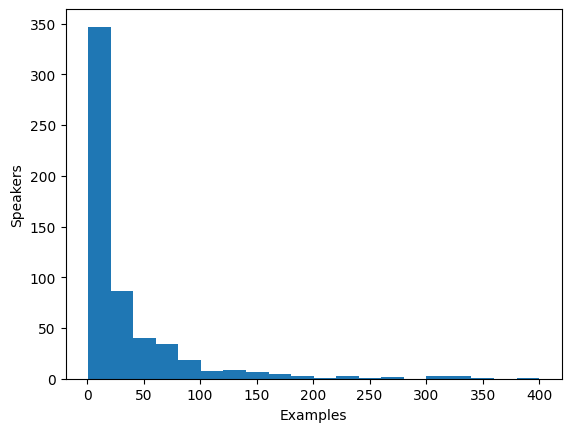

In [22]:
plt.figure()
plt.hist(train_speaker_distribution.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [23]:
def select_speaker(speaker_id):
    return 90 <= train_speaker_distribution[speaker_id] <= 400

In [25]:
train_dataset = train_dataset.filter(select_speaker, input_columns=["speaker_id"])

In [26]:
filtered_data = {key: value for key, value in train_speaker_distribution.items() if value >= 90}
print(len(filtered_data), 'unique speakers.')
print(sum(filtered_data.values()), 'examples.')

56 unique speakers.
9731 examples.


In [13]:
val_dataset = filtered_dataset['validation']

Counter({'28165': 41, '1055': 31, '124992': 30, '125019': 28, '124701': 28, '124955': 26, '124880': 26, '124736': 25, '4274': 25, '28226': 25, '28424': 24, '124957': 24, '5729': 23, '96661': 23, '124743': 21, '125027': 21, '95974': 21, '28243': 21, '96728': 20, '96876': 20, '97009': 20, '28156': 20, '97203': 19, '124969': 18, '197420': 18, '2341': 18, '297129': 17, '1311': 17, '96903': 17, '28139': 17, '96656': 16, '39725': 16, '36214': 16, '197392': 16, '28111': 16, '128588': 15, '96805': 15, '28113': 15, '96812': 15, '124720': 15, '38613': 14, '4552': 14, '124714': 14, '124932': 14, '124852': 14, '2128': 14, '124723': 14, '28305': 14, '197780': 14, '28509': 14, '124789': 13, '28123': 13, '124698': 13, '124989': 12, '96736': 12, '124703': 12, '39721': 12, '119435': 12, '96776': 11, '124903': 10, '95975': 10, '97050': 9, '124943': 8, '28279': 8, '95113': 8, '124840': 8, '118858': 7, '96823': 7, '4549': 6, '125128': 5})


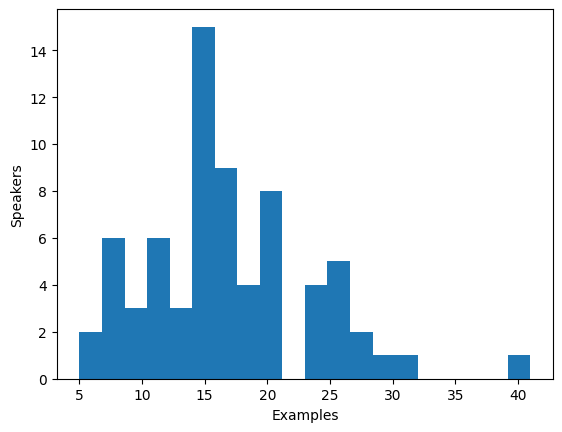

In [ ]:
val_speaker_distribution = analyze_speaker_distribution(val_dataset)
print(val_speaker_distribution)

plt.figure()
plt.hist(val_speaker_distribution.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [ ]:
val_filtered_data = {key: value for key, value in val_speaker_distribution.items() if value >= 1}
print(len(val_filtered_data), 'unique speakers.')
print(sum(val_filtered_data.values()), 'examples.')

70 unique speakers.
1175 examples.


In [14]:
test_dataset = filtered_dataset['test']

Counter({'111014': 24, '97228': 23, '124735': 21, '88882': 21, '96910': 19, '28240': 19, '205452': 17, '197800': 17, '107212': 17, '28149': 17, '36692': 15, '96847': 15, '124698': 15, '96656': 15, '124830': 14, '4267': 14, '96946': 14, '39717': 13, '124996': 13, '28155': 13, '28241': 13, '125025': 12, '96682': 12, '28139': 12, '129256': 12, '96695': 11, '112071': 11, '97344': 11, '96748': 11, '183338': 11, '197769': 10, '96930': 10, '28617': 10, '112014': 10, '96920': 10, '2073': 10, '28514': 10, '96937': 9, '4556': 9, '24942': 9, '124968': 9, '39318': 9, '97019': 9, '2338': 9, '124715': 9, '4265': 9, '124763': 9, '124743': 8, '4470': 8, '33989': 8, '40599': 8, '23746': 8, '4514': 8, '23864': 8, '190519': 7, '1037': 7, '98341': 7, '4508': 7, '4547': 7, '96825': 7, '39722': 7, '124856': 7, '23866': 7, '112760': 6, '28141': 6, '96726': 6, '124962': 6, '107041': 6, '125040': 6, '117477': 6, '28233': 6, '28161': 6, '23938': 6, '4432': 6, '124903': 6, '97156': 6, '1122': 6, '204733': 6, '11

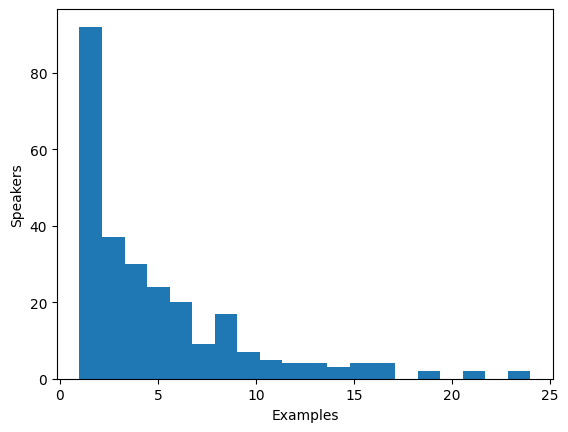

In [ ]:
test_speaker_distribution = analyze_speaker_distribution(test_dataset)
print(test_speaker_distribution)

plt.figure()
plt.hist(test_speaker_distribution.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [ ]:
test_filtered_data = {key: value for key, value in test_speaker_distribution.items() if value >= 1}
print(len(test_filtered_data), 'unique speakers.')
print(sum(test_filtered_data.values()), 'examples.')

266 unique speakers.
1336 examples.


In [15]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [16]:
tokenizer = processor.tokenizer

## 3. Properly cleaned text for tokenization

In [ ]:
def extract_vocab_from_iterable(dataset):
    all_text = []
    for batch in dataset:
        all_text.append(batch["normalized_text"])

    all_text = " ".join(all_text)
    vocab = set(all_text)
    return vocab

dataset_vocab = extract_vocab_from_iterable(val_dataset)

tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}


In [ ]:
dataset_vocab - tokenizer_vocab

{' '}

### Dataset Text is clean ✅

In [ ]:
def clean_text(text):
    text = unidecode(text)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    return text

In [ ]:
example_1 = "Héllo, Wörld! 😊 #Python3"
example_2 = "Äpple çrème brûlée"

cleaned_1 = clean_text(example_1)
cleaned_2 = clean_text(example_2)

print(cleaned_1)
print(cleaned_2)


hello, world! python3
apple creme brulee


## 4. Speaker Embedding

In [17]:
%%capture
!pip install speechbrain

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [19]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [27]:
processed_example = prepare_dataset(next(iter(train_dataset)))
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [28]:
processed_example["speaker_embeddings"].shape

(512,)

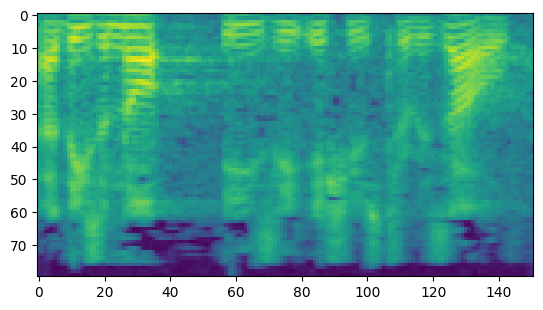

In [29]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [30]:
train_dataset = train_dataset.map(prepare_dataset)
val_dataset = val_dataset.map(prepare_dataset)

In [31]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [32]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [33]:
from huggingface_hub import notebook_login

notebook_login()

In [34]:
from transformers import SpeechT5ForTextToSpeech
from functools import partial
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

model.config.use_cache = False

model.generate = partial(model.generate, use_cache=True)

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_en",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()


config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-34-1ceb5b764d87>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
<ipython-input-31-2cc8fd78303e>:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["speaker_embeddings"] = torch.tensor(speaker_features)


Step,Training Loss,Validation Loss
1000,4.038100,0.476293
2000,3.888800,0.467070


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_write at 0x7a0b2cf45120>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 1254, in vio_write
    @_ffi.callback("sf_vio_write")
KeyboardInterrupt: 


AssertionError: 

In [35]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

events.out.tfevents.1734794007.8c5a3800ab44.180.0:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shahdelrefai/speecht5_finetuned_voxpopuli_en/commit/faa2410180e71913ab5f5f383e98a587d4ec3b3c', commit_message='End of training', commit_description='', oid='faa2410180e71913ab5f5f383e98a587d4ec3b3c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shahdelrefai/speecht5_finetuned_voxpopuli_en', endpoint='https://huggingface.co', repo_type='model', repo_id='shahdelrefai/speecht5_finetuned_voxpopuli_en'), pr_revision=None, pr_num=None)

In [3]:
import torch
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(
    "shahdelrefai/speecht5_finetuned_voxpopuli_en"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

dataset = load_dataset("facebook/voxpopuli", "en", streaming=True)
test_dataset = dataset["test"]
test_dataset = test_dataset.map(prepare_dataset)

In [91]:
example = third_item = next(x for i, x in enumerate(test_dataset) if i == 60)
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [59]:
text = 'hello, i am glad i finished the model.'

In [60]:
inputs = processor(text=text, return_tensors="pt")

In [ ]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [67]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [47]:
from IPython.display import Audio

Audio(speech.numpy(), rate=16000)

In [92]:
text = 'The golden rays of the setting sun painted the horizon with hues of orange and purple, as the distant sound of waves echoed tranquility.'

In [93]:
inputs = processor(text=text, return_tensors="pt")

In [94]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [88]:
Audio(speech.numpy(), rate=16000)

In [87]:
import soundfile as sf

sf.write('audio.wav', speech.numpy(), 16000)

In [ ]:
!pip install pydub

In [81]:
from pydub import AudioSegment
from pydub.playback import play

audio0 = AudioSegment.from_file('audio.wav')

In [89]:
cleaned_audio = audio0.low_pass_filter(2000)

cleaned_audio.export("cleaned_audio.wav", format="wav")
print("Noise reduced and saved to 'cleaned_audio.wav'")

Noise reduced and saved to 'cleaned_audio.wav'


In [90]:
Audio('cleaned_audio.wav')

In [95]:
Audio(speech.numpy(), rate=16000)